# Analysis and comparison of the experimental results

## Comparisons between different MI estimators with AdapLS

In [15]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# MI Ground Truth of Gaussian distribution (Eq.16) with d=6.
mi = 4.982193620464953

Load saved MI estimations.

In [16]:
mi_InfoNCE = torch.load('./results/InfoNCE.pt', map_location='cuda' if torch.cuda.is_available() else 'cpu')['mi_copy']

mi_AdapLS = torch.load('./results/AdapLS.pt', map_location='cuda' if torch.cuda.is_available() else 'cpu')['mi_copy']

mi_PCM = torch.load('./results/PCM.pt', map_location='cuda' if torch.cuda.is_available() else 'cpu')['mi_copy']

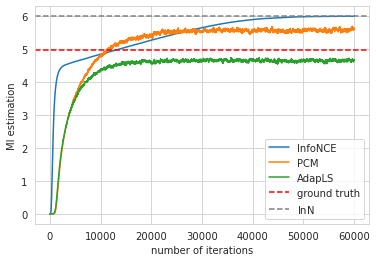

In [17]:
# Plot the MI estimation (Fig.2(b))
plt.plot(mi_InfoNCE, label='InfoNCE')
plt.plot(mi_PCM, label='PCM')
plt.plot(mi_AdapLS, label='AdapLS')
plt.axhline(mi,label='ground truth',linestyle='--',color='red')
plt.axhline(np.log(400),label='$\ln$N',linestyle='--',color='gray')
plt.xlabel('number of iterations')
plt.ylabel('MI estimation')
plt.legend()

## Plot the error of point-wise MI estimates.

Due to the randomness of the training, the plots here are slightly different from the figures in the paper but still consistent with our conclusions.

In [18]:
import scipy.stats as st
import torch
import numpy as np
import matplotlib.pyplot as plt
from data.gaussian import Gaussian

# We set the same random seed to re-generate the same train data.
d = 6
def generate_data(distribution='Gaussian', rho=0.9):
    np.random.seed(0)
    mu1 = 0
    mu2 = 0

    X = np.zeros((400,d))
    Y = np.zeros((400,d))
    mean = np.array([0,0])
    covMat1 = np.array([[1, 0.9], [0.9, 1]])
    covMat3 = np.array([[1, 0], [0, 1]])
    if distribution=='Gaussian':
        mg = Gaussian(sample_size=400,rho=rho)
    else:
        mg = MixedGaussian(sample_size=400,mean1=mu1, mean2=mu2,rho1=rho,rho2=-rho)
    mi = mg.ground_truth * d
    data = mg.data
    prob = np.ones(400)
    for j in range(d):
        data = mg.data
        # Pointwise MI Ground Truth 
        ratio = st.multivariate_normal.pdf(data, mean=mean, cov=covMat1)/st.multivariate_normal.pdf(data, mean=mean, cov=covMat3)
        prob = prob * ratio
        X[:,j] = data[:,0]
        Y[:,j] = data[:,1]
    X = torch.Tensor(X)
    Y = torch.Tensor(Y)
    XY = torch.cat((X, Y), dim=1)
    return XY, X, Y, mi, prob

In [19]:
XY, X, Y, mi, prob = generate_data(distribution='Gaussian', rho=0.9)
# Ground truth of the Pointwise MI based on posterior density p(1|x,y) 
true_output = prob/(prob+1)
true_output = torch.tensor(true_output).reshape(-1,1)

In [20]:
import torch.nn as nn
import torch.nn.functional as F
a, b, c = 0.01, 1e-8, 1-1e-8

def acti_func(x, a, b, c):
    alpha = torch.zeros_like(x)
    x_cpu = x.cpu()
    alpha[np.where(x_cpu.cpu()<=b)] = - a*x[np.where(x_cpu<=b)]/b + a
    alpha[np.where((x_cpu>b) & (x_cpu<c))] = 0
    alpha[np.where(x_cpu>=c)] = a*x[np.where(x_cpu>=c)]/(1-c) + a*c/(c-1)
    return alpha

# Define the network structure of AdapLS
class Net1(nn.Module):
    # Inner class that defines the neural network architecture
    def __init__(self, input_size=2, hidden_size=100, sigma=0.02):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 1)
        nn.init.normal_(self.fc1.weight, std=sigma)
        nn.init.constant_(self.fc1.bias, 0)
        nn.init.normal_(self.fc2.weight, std=sigma)
        nn.init.constant_(self.fc2.bias, 0)
        nn.init.normal_(self.fc3.weight, std=sigma)
        nn.init.constant_(self.fc3.bias, 0)

    def forward(self, input):
        output = F.elu(self.fc1(input))
        output = F.elu(self.fc2(output))
        output = F.sigmoid(self.fc3(output))
        alpha = acti_func(output, a, b, c)
        return output, alpha

# Define the network structure of PCM
class Net2(nn.Module):
    # Inner class that defines the neural network architecture
    def __init__(self, input_size=2, hidden_size=100, sigma=0.02):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 1)
        nn.init.normal_(self.fc1.weight, std=sigma)
        nn.init.constant_(self.fc1.bias, 0)
        nn.init.normal_(self.fc2.weight, std=sigma)
        nn.init.constant_(self.fc2.bias, 0)
        nn.init.normal_(self.fc3.weight, std=sigma)
        nn.init.constant_(self.fc3.bias, 0)

    def forward(self, input):
        output = F.elu(self.fc1(input))
        output = F.elu(self.fc2(output))
        output = F.sigmoid(self.fc3(output))
        return output

In [21]:
# Initialize the networks
AdapLS_net = Net1(input_size=d*2, hidden_size=100)
PCM_net = Net2(input_size=d*2, hidden_size=100)
# Load the pre-trained parameters
AdapLS_state = torch.load('./results/AdapLS.pt')['model_state']
PCM_state = torch.load('./results/PCM.pt')['model_state']
AdapLS_net.load_state_dict(AdapLS_state)
PCM_net.load_state_dict(PCM_state)

<All keys matched successfully>

In [22]:
# Define pointwise MI error (Eq.17 in the paper)
def error(truth, data):
    return torch.log(data/truth) + torch.log((1-truth)/(1-data))

In [23]:
# Compute the posterior density p(1|x,y).
adapLS_pcm, _ = AdapLS_net(XY)
pcm = PCM_net(XY)
# Compute the pointwise MI error
bias_pcm = error(true_output, pcm)
bias_alspcm = error(true_output, adapLS_pcm)

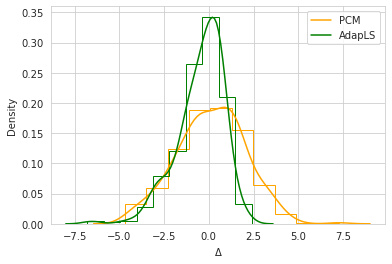

In [24]:
import seaborn as sns
# Plot the error of the pointwise MI estimate (Fig.2(b))
sns.set_style("whitegrid")
sns.kdeplot(data=bias_pcm.detach().cpu().numpy().reshape(400),label='PCM', color="orange")
sns.kdeplot(data=bias_alspcm.detach().cpu().numpy().reshape(400), label='AdapLS', color="green")
plt.hist(bias_pcm.detach().cpu().numpy(),density=True, histtype='step', color="orange")
plt.hist(bias_alspcm.detach().cpu().numpy(), density=True, histtype='step', color="green")
plt.xlabel('$\Delta$')
plt.ylabel('Density')
plt.legend()